In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tick.hawkes import HawkesExpKern
from tick.hawkes import HawkesEM
import tick
import dill as dill

# Question 3


In [6]:
eurusd = pd.read_csv("eurusd.csv", header = None)
eurusd.columns = ["Time", "Bid", "Ask"]
eurusd.Time -= eurusd.Time[0] 
eurusd_array = eurusd.values
eurusd.head(5)

,Time,Bid,Ask
0,0.000,1.13747,1.13908
1,1.159,1.13746,1.13919
2,2.965,1.13736,1.13855
3,3.026,1.13712,1.13856
4,3.081,1.13718,1.13901


We can see the Time column is in increasing order so, we are all good.

### Part (a)

In [7]:
trade_tick = HawkesExpKern(1)
trade_tick.fit([np.asarray(eurusd_array[:,0],order='C')])

baseline = trade_tick.baseline
adjacency = trade_tick.adjacency

print("Baseline is: ", baseline)
print("Adjacency is: ", adjacency)


Baseline is:  [0.13194047]
Adjacency is:  [[0.86685402]]


Baseline gives the number of trades per unit time or constant rate of trades without incorporating any other effect going forward. Meaning, assuming no influence from other trades, there are approximately 0.1319 trades per unit time.
Adjacency tells us how one trade order occurance can affect/influence/stimulate the market and results into more trade events. We expect the effect of one trade to decay out with time. For this data, we can see 0.8668 to be the multiplier in the exponential decay of the influence.

Thus expected rate of trades per second would be the baseline which is 0.1319 and adjacency factor is the expected number of trades stimulated by each trade which is 0.8668.


### Part (b)

In [8]:
decays = np.array(range(1,30,1)).astype(float)
adjacency = np.zeros(decays.shape)
baseline = np.zeros(decays.shape)
scores = np.zeros(decays.shape)

for i in range(len(decays)):
    decay = decays[i]
    trade_tick = HawkesExpKern(decay)
    trade_tick.fit([np.asarray(np.sort(eurusd_array[:,0]),order='C')])

    baseline[i] = trade_tick.baseline
    adjacency[i] = trade_tick.adjacency
    scores[i] = HawkesExpKern.score(trade_tick)

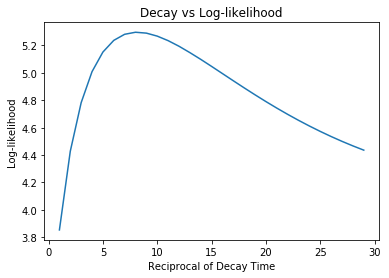

In [9]:
plt.plot(decays, scores)
plt.xlabel("Reciprocal of Decay Time")
plt.ylabel("Log-likelihood")
plt.title("Decay vs Log-likelihood")
plt.show()

We can see that the log-likelihood reaches a maximum at around a decay value of 8 and then goes down. This implies that there is a certain decay parameter where the dataset has maximum log-likelihood which means that the average decay time of the self-excitation event is 1/8 or around 0.125 seconds.

### Part (c)

In [34]:
trade_tick_kernel = HawkesEM(kernel_support = 1)
trade_tick_kernel.fit([np.ascontiguousarray(np.sort(eurusd_array[:,0]))])

baseline_kernel = trade_tick_kernel.baseline
print(baseline_kernel)

[0.32363026]


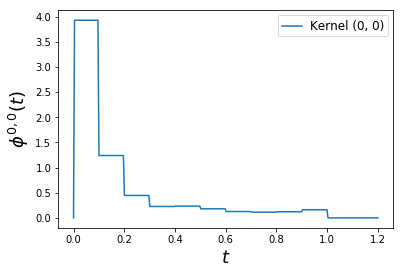

In [30]:
tick.plot.plot_hawkes_kernels(trade_tick_kernel)
plt.show()

Above can be interpreted as a probability density of the trades influenced by prior trade and the time for that next trade. To answer the question as to how quickly does one trade gets caused by prior trade, we need to calculate the expected value of the above density. We can make a guess by looking at the graph about the mean of the distribution, but for more precise estimate we should calculate the probability density weighted average of the time. My guess from the plot would be between 0.1-0.2 seconds. 

Note that this is also inline with the decay parameter corresponding to max log-likelihood in part (b). Thus the kernel based Hawkes model captures the most likely decay time based on the data as we can see that the mean decay time matches between this part and part (b)

Also the baseline value is 0.3236 which means 0.3236 trades per seconds are generated from background which means approximately one trade is generated per second from background whereas trades stimulated by events occur with an average time of 0.15 seconds. Thus our model thinks most of the trades are stimulated by other events.

### Part (d)

In [45]:
eurusd['MidPrice'] = (eurusd.Bid + eurusd.Ask)/2
eurusd['PriceChange'] = np.append(np.diff(eurusd.iloc[:,3])[::-1], None)[::-1]
eurusd_increase = eurusd[eurusd['PriceChange'] > 0]
eurusd_decrease = eurusd[eurusd['PriceChange'] < 0]

In [47]:
increase_time_ticks = np.ascontiguousarray(np.sort(eurusd_increase.values[:,0])).astype(float)
decrease_time_ticks = np.ascontiguousarray(np.sort(eurusd_decrease.values[:,0])).astype(float)

mutual_fit = HawkesExpKern(decays=10.0)
mutual_fit.fit([increase_time_ticks, decrease_time_ticks])

In [50]:
print("Baseline")
print(mutual_fit.baseline)

print("Adjacency")
print(mutual_fit.adjacency)

Baseline
[0.20373702 0.20425652]
Adjacency
[[0.4242209  0.1647993 ]
 [0.16676291 0.42228355]]


We can observe that both increase and decrease events stimulate other increase, decrease events. By looking at the adjacency numbers, we can see that an increase event stimulates another subsequent increase event with higher probability/rate compared to stimulating a subsequent decrease event. Thus after a price increase event, another increase is more likely than a decrease.

And similarly, a decrease event stimulates amother decrease event with larger probability than a subsequent increase event. Also, after a price decrease event, another decrease is more likely than an increase.

As we can see, both increase and decrese events stimulates other increase and decrease events. However, an increase event stimulates increase event with higher intensity compare to the decrease, and vice versa.

A very fundament assumption in logistic regression models is that the observations are independent and hence doesn't affect each other, whereas we are trying to model the influence of one event on the next occurrence. 

If we try learning a logistic regression model with a prior value of the event, then it results into the probability of an increase/decrease and the coefficients can be compared to the adjacency values. One more difference is the fact that logistic regression won't provide any distribution of the time for next event but only a point probability. The Hawkes model though, will provide a distribution of the probability of the event which allows us to think about expected number of events within a certain time interval and also combining effect of multiple events on an overlapping time interval.

If two successive events happen, the calculated adjacency values will remain same and if the adjacency is large enough compared to the decay time, two successive event would combine the influence and will result into increase in predicted rate of future events.

# Question 4

Thank You!